# プログラミング演習第11回課題  
以下に学籍番号と氏名を入力下さい．

学籍番号：BGA22078  
氏名：中谷友哉

今回はpytorch を使って簡単な畳み込みニューラルネットワークの実装をします．　　
## PyTorch モジュールのimport
まずはpytorch モジュールの読み込みをします．また，PyTorchプロジェクトに含まれているパッケージのうち，コンピュータビジョンのための一般的なデータセット，モデルアーキテクチャ，および一般的な画像変換から構成されるtorchvision も併せて読み込みします．

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## 利用データ・読み込み方法  
今回，画像認識をするのにトロント大学が提供しているCIFAR 10 というデータセットを利用します．詳細は[ここ](https://www.cs.toronto.edu/~kriz/cifar.html)に掲載されています．  
CIFER-10には，10クラス，60,000枚の32X32 pixels の画像が存在しており，50,000枚は学習データ，10,000枚はテストデータとして利用します．  
PyTorch では，データを多次元型の配列を表現し，かつ，GPU での演算が可能なテンソル型で表現します．そのため，データの読み込み際に，テンソル型に変換してからデータを読み込みます．  
また，学習をおこないやすくするため，テンソル型に変換したのち，画像の3チャネルの画素値の平均と分散を0.5 に正規化します．  
データの読み込みにはtorchvisionに用意されているCIFAR10を利用します．そして，DataLoaderを使ってバッチサイズ（学習に使われる1単位のデータ集合の数）ごとにデータを分割します．

In [2]:
#読み込みの際の一連の画像変換をまとめて記載
transform = transforms.Compose(
    [transforms.ToTensor(),#テンソル型にデータを変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#平均，分散をそれぞれ0.5 に設定

#バッチサイズの決定
batch_size = 4

#学習データの読み込み
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#学習データのDataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#テストデータの読み込み
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#テストデータのDataLoader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
#データのクラス
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


データにどのような画像が含まれているか，1つのバッチを見てみましょう．
テンソル形式の画像データをnumpy 形式に変換し，matplotlib を使って表示させます．


Bad key text.latex.preview in file /Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/m1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/m1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/nakatani/.pyenv/versions/anaconda3-5.3.0/envs/m1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_

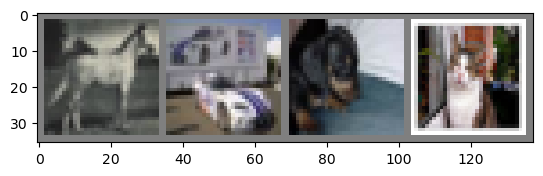

horse car   dog   cat  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# データの表示するモジュール
def imshow(img):
    img = img / 2 + 0.5     # 正規化前に画像を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 学習データのバッチを1つ取ってくる
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルデータの表示
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## ネットワークの構築
ネットワークをどのようにして作成するか説明します．
まずは，ニューラルネットワークのパッケージと，その関数のパッケージを読み込みます．

In [5]:
import torch.nn as nn
import torch.nn.functional as F

続いて，ネットワークの構造を記載します．  
ここでは，nn.Module クラスを継承して，サブクラスを定義する方法を紹介します．  
nnパッケージには，ニューラルネットワークでのネットワーク構成に必要な関数がそれぞれ用意されています．それを用いてネットワークを構築していきます．  
代表的なものは以下のものです．引数，用途などの関数の詳細は[PyTorchのnnパッケージの説明サイト](https://pytorch.org/docs/stable/nn.html#convolution-layers)を参考にして下さい．  

- **nn.Conv2D**　2次元の畳み込み積分を行います．
- **nn.MaxPool2d** 2次元の最大値プーリングを行います．
- **nn.Linear** 線形変換を行います．全結合層に使われます．

ネットワークの定義では，まず，コンストラクタに自分の利用したいレイヤーを宣言します．続いて，foward 関数で，モデルを入力から出力まで，どのように接続するかを定義します．  
例として，以下のネットワークを組んでみます．  

**入力** : 28X28 ピクセルのグレースケール（1 channel）画像  
- カーネルサイズが3X3で，出力の特徴マップのチャネルが2の2次元畳み込み積分をして，その結果にReLU 関数を施す 
- 着目領域を2X2ピクセル，ストライド2ピクセルとして2次元の最大値プーリングを行う
- 特徴マップを1つの特徴ベクトルに平坦化
- 全結合層で特徴ベクトルを6次元ベクトルに変換  

**出力** : ６次元ベクトル  


In [6]:
class _samplenet( nn.Module ):
    #コンストラクタの定義（ネットワークの中で利用したいレイヤーの宣言）
    def __init__(self):
        super().__init__()#superクラス（親クラス）のコンストラクタを呼び出し
        self.conv =  nn.Conv2d( 1, 2, 3 )#入力画像のチャネルが1，カーネル数2，カーネルサイズ3X3の2次元畳み込み積分レイヤー
        self.pool = nn.MaxPool2d( 2, 2 )#2X2 の領域を用い，ストライド2 で2次元MaxPoolingを行うレイヤー 
        self.fc = nn.Linear( 13*13*2, 6 )#入力が13*13*2 の全結合レイヤー

    #forward モジュールの定義，x: 入力
    def forward( self, x ):
        x = self.pool(F.relu(self.conv(x)) )#入力に対して畳み込み積分を行った後，relu 関数を施して，プーリング
        x = tourch.flatten( x, 1 )#特徴を一つのベクトルに平坦化
        x = self.fc(x)#全結合層
        return x   

ネットワークの構築で注意すべきところは，生成された特徴マップの次元数です．  
$k \times k$のカーネルによる2次元の畳み込みの際に生成される特徴マップは，一般的に入力の画像サイズが$W \times H$の場合，$(W-(k-1)) \times (H-(k-1))$となります．  
上記の例では，入力画像が28X28ピクセル，カーネルサイズが3X3であったことから，特徴マップのサイズは26X26となります．  
そして，着目領域が2X2，ストライドが2で最大値プーリングを施すと，特徴マップのサイズは縦，横方向がそれぞれ1/2のサイズとなることから，13X13になります．  
2次元畳み込み積分の際の出力の特徴マップのチャネルを2にしていたので，2次元畳み込み積分，relu 関数を施してプーリングし，平坦化したときの特徴は13X13X2となります.  
そのため，上記の```nn.Linear``` 最初の引数が 13\*13\*2となっているわけです．

定義ができたところで，ネットワークがどのようになっているか表示をさせてみましょう．

In [7]:
samplenet = _samplenet() #samplenetのインスタンスを作成
print( samplenet )#表示

_samplenet(
  (conv): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=338, out_features=6, bias=True)
)


ネットワークのカーネルのサイズや構造が表示されたかと思います．
## 課題1：指定のネットワークを構築
それでは，実際にネットワークを組んでみましょう．  
今回用いるCIFAR-10は32X32ピクセルのカラー画像で．カテゴリが10個あるため，入力を32X32 ピクセルのカラー（3 channels）画像，出力はベクトルの各要素が対応するカテゴリに属する程度を示す10次元のベクトルとします．

**入力** : 32X32 ピクセルのカラー（3 channels）画像  
- カーネルサイズが5X5，出力の特徴マップのチャネルが6の2次元畳み込み積分をして，その結果にReLU 関数を施す
- 着目領域を2X2ピクセル，ストライド2ピクセルとして2次元の最大値プーリングを行う
- カーネルサイズが5X5，出力の特徴マップのチャネルが16の2次元畳み込み積分をして，その結果にReLU 関数を施す
- 着目領域を2X2ピクセル，ストライド2ピクセルとして2次元の最大値プーリングを行う
- 特徴マップを1つの特徴ベクトルに平坦化
- 全結合層で特徴ベクトルを120次元に変換し，ReLU関数を施す
- 全結合層で特徴ベクトル84次元に変換し，ReLU関数を施す
- 全結合層で特徴ベクトルを10次元に変換する

**出力** : 10次元ベクトル  

下記セルにネットワークを記述して下さい．

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        #レイヤー接続の定義を記入
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        return x

ネットワークが指示通り組めたか，インスタンスを作成して出力します．

In [9]:
net = Net()
print( net )

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


正しく組めているようであれば，以下のように出力されるはずです．但し，レイヤーの名称（各行の先頭の括弧内の文字）は各個人で異なるので，必ずしも一致しません．
```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

## Loss と最適化アルゴリズム
ネットワークが構築できたら，次はloss と最適化アルゴリズムを指定しましょう．
PyTorch には，最適化アルゴリズムのパッケージoptim が用意されていますので，まずはそちらをimport します．

In [10]:
import torch.optim as optim

## 課題2：Loss 関数と最適化アルゴリズムの設定
今回，10クラス識別問題ということで，loss function にはクロスエントロピーを，最適化アルゴリズムはニューラルネットワークのパラメータ決定によく使われる確率的勾配降下法(stochastic gradient descent, SGD)を下のコードブロックでインスタンスを生成することで指定しましょう．   
[loss function一覧](https://pytorch.org/docs/stable/nn.html#loss-functions)から，クロスエントロピーを指定して下さい．パラメータはデフォルトのままで指定する必要はありません.  
[最適化アルゴリズム一覧](https://pytorch.org/docs/stable/optim.html#algorithms)から，今回はSGDを選んで以下のコードブロックで指定して下さい．gamma（学習率）の値を0.001, momentum を0.9 に指定して下さい．

In [11]:
#loss の指定（None を書き換える）
criterion = F.cross_entropy
#最適化アルゴリズムの指定（None を書き換える）
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 学習
ネットワークの定義と，Loss 関数，最適化アルゴリズムの指定ができたので，次は学習です．
変数``epoch``は，学習データネットワークに学習させた回数を示しており，今回は2回にしています．

In [12]:
for epoch in range(2):  #データ全体を2回学習させる

    #学習データのロス
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #Dataloader から入力されたデータを入力（画像データ）正解ラベルに分割
        inputs, labels = data

        # 最適化アルゴリズムの勾配を0に設定して初期化
        optimizer.zero_grad()

        #現状のパラメータを用いて，画像が入力された時の出力結果を計算
        outputs = net(inputs)
        #ネットワークの出力と正解ラベルからloss を計算
        loss = criterion(outputs, labels)
        #lossから誤差逆伝搬法を適用
        loss.backward()
        #SGD によるネットワークパラメータの更新
        optimizer.step()

        # 学習の状態の出力
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000バッチごとに出力
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.289
[1,  4000] loss: 2.133
[1,  6000] loss: 1.877
[1,  8000] loss: 1.732
[1, 10000] loss: 1.561
[1, 12000] loss: 1.507
[2,  2000] loss: 1.418
[2,  4000] loss: 1.387
[2,  6000] loss: 1.354
[2,  8000] loss: 1.349
[2, 10000] loss: 1.333
[2, 12000] loss: 1.299
Finished Training


学習した結果を一旦保存します．

In [13]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 識別器の評価  
テストデータを用いて識別器を評価します．まずは，テストデータの1つ目のバッチがどのようなもか見てみましょう．

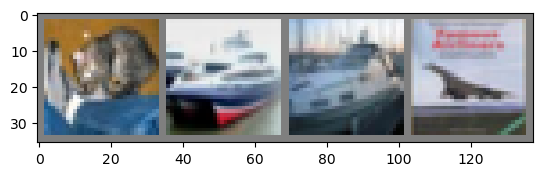

GroundTruth:  cat   ship  ship  plane


In [14]:
#イテレータを使って，テストデータの最初のバッチにアクセス
dataiter = iter(testloader)
#画像データと正解ラベルに分割
images, labels = dataiter.next()

# 出力
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

それでは，学習したネットワークのパラメータを読み込み，これらを識別してみましょう．

In [15]:
#インスタンス生成
net = Net()
#学習結果を読み込み
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

画像データをネットワークに入力して，出力結果がどうなっているかを見ましょう．
ネットワークの出力は，10次元のベクトルとなっており，その中で最大の値が対応する画像クラスになるように学習されています．ですので，出力されたベクトルの位置で最大のもの該当するクラスを出力します．

In [16]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   truck


正解データと比較してどうでしたでしょうか？
それでは，全てのテストデータで評価を行い，精度を出力してみましょう．

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 画像データをネットワークに入力して計算
        outputs = net(images)
        #10次元ベクトルのうち，最も大きい値を示す要素に対応するカテゴリを識別結果とする
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #正しく認識されたものの数を数える
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


## 課題3：各クラスでの認識精度を算出
上記を参考に，それぞれの画像クラスでの精度を計算してみましょう．精度は（各クラスで正しく正解したテスト画像数）/（各クラスのテスト画像総数）となります．
出力は
```
plane : 0.XXXX 
car   : 0.XXXX 
bird  : 0.XXXX 
cat   : 0.XXXX
deer  : 0.XXXX 
dog   : 0.XXXX 
frog  : 0.XXXX 
horse : 0.XXXX 
ship  : 0.XXXX 
truck : 0.XXXX
```
という形で結構です．

In [18]:
#各クラスの精度を計算し，出力するコードを書いて下さい．
correct = [0]*10
total = [0]*10
false_cnt = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 画像データをネットワークに入力して計算
        outputs = net(images)
        #10次元ベクトルのうち，最も大きい値を示す要素に対応するカテゴリを識別結果とする
        _, predicted = torch.max(outputs.data, 1)
        for l, p in zip(labels, predicted):
            false_cnt += int(p != l)
            correct[l.item()] += int(p == l) # add 0 or 1
            total[l.item()] += 1
        

print(''.join(f'{classes[i]:5s}: {crct/ttl}\n' for i, crct, ttl in zip(range(10), correct, total)))
assert np.sum(correct) + false_cnt==10000, print('failed to count up')


plane: 0.58
car  : 0.733
bird : 0.284
cat  : 0.181
deer : 0.424
dog  : 0.588
frog : 0.616
horse: 0.695
ship : 0.476
truck: 0.738



## 課題4：精度の考察
今回の認識精度ですが，おおよそ50%程度であったかと思います．認識精度を改善させるためには，学習でどのような改善をする必要があるか，その案を下記に記入して下さい．  
記入欄はテキストボックスにしていますが，Markdown 形式にボックスの書式を変更して書いても問題ありません．

* 畳み込み層を多数重ねてdeepなネットワークに置き換える．
* 大域的な情報と局所的な情報を組み合わせるような機構(skip connection)を取り入れる．
* validationデータによってハイパーパラメータを調整した後にテストを行う．
* data augmentationを行って学習データを増やす．
* 学習のエポックを増やす．

**お疲れ様でした！！！**  
最初のテキストボックスに学籍番号と氏名を記入し，全てのセルを実行済みにして保存したのち，[moodle](https://lms.omu.ac.jp/mod/assign/view.php?id=743958)から提出して下さい．提出期限は6/30 23:59 です．